# Adaboost

The point of this workbook is to create some fake data, then solve for the class using Adaboost.

None of the code here is taken from the Coursera course.  This exercise is completed in order to apply the lessons learned without code assistance as well as elaborate on some aspects.

For this workbook we're leaning hard on different Python packages.  For fitting our trees we're using scikit learn.

You can find the Adaboost algorithm from the Coursera Machine Learning Specialization Classification Course, Week 5 video "Example of Adaboost in Action" which shows the following:

<img src="https://github.com/yeamusic21/Coursera-Machine-Learning-Specialization-Extra-Assignments/blob/master/Classification/img/adaboost_algorithm.PNG?raw=true">

## Create Some Fake Data to Fit

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

So the idea here is to create some kind of data with a bit of structure and noise and then create a decision boundry to create our dependent variable.  The creation for X1 and X2, our independent variables don't necesarrily make a lot of sense, I'm just basically playing around to create some fake data to model.

In [3]:
#### CREATE FAKE DATA

# simulate some data
column1 = np.repeat(1, 100)
column2 = np.arange(-5,5,.1)
column3 = (column2**2)/1
column4 = (column2**3)/10
column5 = (column2**4)/100
Xplay = np.matrix([column1,column2,column3,column4,column5])
Xplay = Xplay.transpose()
# save column1 from Xplay as our first modeling variable
X1 = Xplay[:,1]
# make up some parameters
B = np.matrix(np.array([5.0345,2.0961,2.5109,1.0432,3.6657]))
B = B.transpose()
# create some fake noise
e = np.matrix(np.random.normal(0, 19, 100))
e = e.transpose()
# finally, create another fake variable using an arbitrary function with noise
X2 = Xplay*B + e

# now we're going to set some arbitrary line to pick our 1's and 0's
# and we'll add some noise so it's not perfectly linearly separable
bound = np.arange(min(X2),max(X2),(max(X2)-min(X2))/len(X2))
Y = []
for i in range(100):
    if X2[i] + np.random.normal(0, 40, 1) > bound[i]:
        Y.append(+1)
    else:
        Y.append(-1)

# reformat Y
Y = np.matrix([Y])
Y = Y.transpose()

Now lets take a look at the data we created and that we're going to try and model

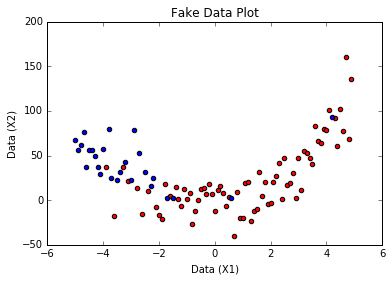

In [4]:
# plot our fake data to make sure it looks as we would expect

mask1 = Y!=+1
mask0 = Y!=-1

X1f = X1.flatten()
X2f = X2.flatten()

intercept = np.matrix(np.repeat(1, 100))
X = np.concatenate((intercept.transpose(),X1,X2),axis=1)

plt.scatter(X1f[mask1.ravel()], X2f[mask1.ravel()],c='red')
plt.scatter(X1f[mask0.ravel()], X2f[mask0.ravel()],c='blue')
plt.title('Fake Data Plot')
plt.xlabel("Data (X1)")
plt.ylabel("Data (X2)")
plt.show()

### Fit Adaboost using Classification Tree as Base Learner

I wanted to use dynamic variables, but I had a bit of trouble.  I used the following article as a reference.

*Resource or creating dynamic variables:* http://stupidpythonideas.blogspot.com/2013/05/why-you-dont-want-to-dynamically-create.html

But when I set everything up, every model just returned the predictions of the final model.  Not sure why it was giving me trouble (not the 1st time with Python) so instead I just dropped the dynamic variables and scored the data as I was training.

In [5]:
# imports
import time
from sklearn.tree import DecisionTreeClassifier

In [6]:
# create function that will compute the new weight of the latest learner
def get_weight(target,predicted, weights):
    weight = 0
    for i in range(len(target)):
        if target[i,]!=predicted[i,]:
            weight += weights[i]
    return weight/sum(weights)

In [7]:
# create function that will compute new weights for each data point
def new_weights(target,predicted, weights, model_wgt):
    for i in range(len(target)):
        if target[i,]==predicted[i,]:
            weights[i] = weights[i]*np.exp(-model_wgt) 
        else:
            weights[i] = weights[i]*np.exp(model_wgt) 
    # Normalize before returning
    weights = weights / sum(weights)
    return weights

In [8]:
# set some of the hyperparameters
rounds = 50
mydepth = 1

# define training data
X = np.concatenate((X1,X2),axis=1)

#initialize weights
weights = np.repeat(1/float(len(X)),len(X))

# define classifier as classification tree with set depth
clf = DecisionTreeClassifier(max_depth=mydepth)

# create list for saving weight history
wgt_history = []

# initialize scores
scores = np.repeat(0.0,len(Y))

# Train Adaboost
for i in range(rounds):
    # create model
    model = clf.fit(X,Y,sample_weight=weights)
    # compute predictions
    predicted = model.predict(X)
    # transpose predictions for next step
    predicted_t = np.matrix(predicted).transpose()
    #compute weighted_error for this model/learner
    weighted_error = get_weight(target=Y,predicted=predicted_t, weights=weights)
    #compute weight for this model/learner
    weight = 0.5*np.log((1-weighted_error)/weighted_error)
    #reweight data
    weights = new_weights(target=Y,predicted=predicted_t, weights=weights, model_wgt=weight)
    # calculate scores as we train, for calculating predictions later on
    scores += weight*model.predict(X)
    wgt_history.append(weight)

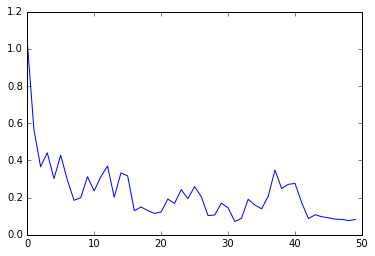

In [9]:
# plot weight history
x = np.arange(0,rounds,1)
plt.plot(x,wgt_history)

Pretty interesting that the weak learner weights kind of resemble an error plot.  Also, the weights kind of feel like the gradient values because they approach 0, i.e. get smaller and smaller as we go forward (kind of like in gradient descent as we approach our cost minimum).  

What is really going on is as we focus more and more on the troublesome points we have less confidence in those learners, but as an overall learner these are, in a sense, making fine adjustments to help us capture more.  This is going to help us "boost" our model i.e. make better predictions.  Pretty cool!  

In [11]:
# determine final predictions from scores
predictions = []
for k in range(len(X)):
    if scores[k]>0:
        predictions.append(+1)
    else:
        predictions.append(-1)

Now let's plot our results!

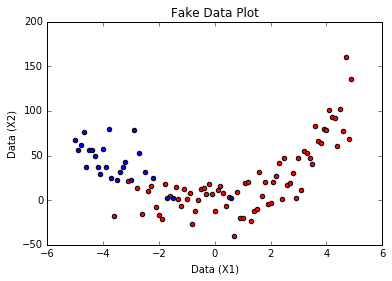

Accuracy: 0.96


In [18]:
#### PLOT ADABOOST RESULTS

# training data
X = np.concatenate((X1,X2),axis=1)

# get predicted
predicted = predictions
predicted = np.matrix(predicted).transpose()

# compute masks for plotting
mask1 = predicted!=+1
mask0 = predicted!=-1

# reformat for plotting
X1f = X[:,0].flatten()
X2f = X[:,1].flatten()

# plot results
plt.scatter(X1f[mask1.ravel()], X2f[mask1.ravel()],c='red')
plt.scatter(X1f[mask0.ravel()], X2f[mask0.ravel()],c='blue')
plt.title('Fake Data Plot')
plt.xlabel("Data (X1)")
plt.ylabel("Data (X2)")
plt.show()

# compute and print accuracy
correct = 0
for i in range(len(Y)):
    if Y[i,]==predicted[i,]:
        correct += 1
print "Accuracy:",correct / float(len(Y))

Great!  96% on training!  That's pretty awesome that we did it!  Obviously we don't know how it generalizes, but this was not in scope for this workbook.  The main thing I wanted to do was code it up from scratch and show it working properly, which we did!  Hooray! 